# Federated Learning Experiment
##Scenario System Design

In [1]:
#install package for encryption
!pip install phe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.1 MB/s eta 0:00:00


In [2]:
#import libraries
import os
import math
import time
import numpy as np
import pandas as pd
import phe.encoding
from phe import paillier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import metrics
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot
from warnings import filterwarnings

filterwarnings("ignore")

#Experiment – Privacy Technology company offering pretrained model to financial institutions.



PTFI provides state of the art AI solutions to combat financial crime. It offers pretrained model as a service. On top that it is using privacy enhancing technologies to keep sensitive data private for all parties involved.



**Scenario (Use Case)**

We have a pretrained classifier model that predicts credit fraud. We specialise in building state of the art models to combat financial crime.

A bank wants to use our model to predict credit fraud on using their own data.



**How do we do this?**

Train credit fraud classifier model on server (our) using the encrypted synthetic data (That is why we need a synthetic data related to credit transactions with a target variable fraudulent credit transaction)

Encrypt the data of the bank.

1.   Encrypt the data of the bank.
2.   Send the encrypted test data (bank data) to the server (ours)
3.   Use unencrypted model parameters for inference.
4.   Send model predictions back to the bank.
5.   The bank will decrypt output predictions and calculate accuracy.


This is experiment can be done using python. This is a simple example showing how privacy preserving technology like HE and federated learning can be utilised to combat financial crime.

In [6]:
#import image libraries
from google.colab import files
from IPython.display import Image

In [7]:
#load image
uploaded = files.upload()

Saving Fed_Learning.png to Fed_Learning.png


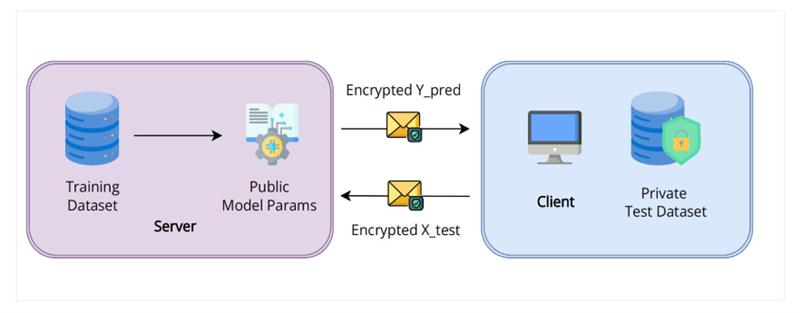

In [8]:
#Show image
Image('Fed_Learning.png')

In [3]:
# Functions

class ExampleEncodedNumber(phe.encoding.EncodedNumber):
    BASE = 64
    LOG2_BASE = math.log(BASE, 2)

def encrypt_vector(vec, public_key):
  # encoded_vector = [ExampleEncodedNumber.encode(public_key, v) for v in vec]
  # encrypted_vector = [public_key.encrypt(ev) for ev in encoded_vector]
  encrypted_vector = [public_key.encrypt(ev) for ev in vec]
  return encrypted_vector

def decrypt_vector(vec, private_key):
  # decoded_vector = [private_key.decrypt_encoded(x, ExampleEncodedNumber) for x in vec]
  # decrypted_vector = [d.decode() for d in decoded_vector]
  decrypted_vector = [private_key.decrypt(x) for x in vec]
  return decrypted_vector

def load_data(input_file, target_feature):
  # Load data and separate the features and labels
  data = pd.read_csv(input_file).dropna()
  X = data.drop(target_feature, axis=1).values.tolist()
  y = data[target_feature].values.tolist()
  return X, y


##Bank Server

The bank dataset is encrypted using homomorphic encryption

In [4]:
class Client:

    def __init__(self, key_length):
        # Generate the public and private keys for Paillier encryption
        public_key, private_key = paillier.generate_paillier_keypair(n_length=key_length)
        self.public_key, self.private_key = public_key, private_key

    def encrypt_data(self, input_file, target_feature):
        # Encrypt the testing data and labels
        self.X_test, self.y_test = load_data(input_file, target_feature)
        self.X_test_encrypted = [encrypt_vector(x, self.public_key) for x in self.X_test]
        self.y_test_encrypted = encrypt_vector(self.y_test, self.public_key)
        return self.X_test_encrypted, self.y_test_encrypted

    def eval(self, encrypted_predictions):
        logits = decrypt_vector(encrypted_predictions, self.private_key)
        y_pred = [1 if l>0 else 0 for l in logits]
        test_accuracy = accuracy_score(self.y_test, y_pred)
        return test_accuracy

##PTFI Server

We are using SVM Classifier model. Here we create the prediction model. The PTFI dataset is not encrypted as the SVM Classifier model is located in our server.


In [5]:
class Server:

    def __init__(self, input_file, target_feature):
        self.model = None
        self.X_train, self.y_train = load_data(input_file, target_feature)

    def train_model(self,hyperparams):
        # Train the SVM model
        svm_model = SVC(kernel=hyperparams['kernel'], C=hyperparams['C'], gamma=hyperparams['gamma'])
        svm_model.fit(self.X_train, self.y_train)
        self.model = svm_model

    def predict(self, X_test_encrypted):
        # Make predictions on the encrypted test data using the trained model
        encrypted_logits = list()
        w = self.model.coef_[0]
        b = self.model.intercept_[0]
        for x in X_test_encrypted:
          score = b
          for i in range(len(x)):
            score += x[i]*w[i]
          encrypted_logits.append(score)
        return encrypted_logits

#Load dataset

In [ ]:
df = pd.read_csv('/content/synthetic_financial_data.csv')
df.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
0,1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
1,2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053
2,3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035
3,4,1095,2037,7619.05,2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037
4,5,1036,2083,1890.10,2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083


In [ ]:
#Drop column not needed
cols = ['transaction_time','card_type','location','purchase_category','transaction_description']

df = df.drop(cols, axis=1)
df.head()

,transaction_id,customer_id,merchant_id,amount,is_fraudulent,customer_age
0,1,1082,2027,5758.59,0,43
1,2,1015,2053,1901.56,1,61
2,3,1004,2035,1248.86,1,57
3,4,1095,2037,7619.05,1,59
4,5,1036,2083,1890.10,1,36


Data Transfer code

Lets assume that we our SVM model will predict fraud. We first train model in our server with our own dataset. Then we encrypt the bank dataset on the bank server machine.The bank will than send the encrypted data to our server to use our model to predict fraud with their own dataset. Then we send the encrypted output prediction back to the bank where the bank will decrypt the output prediction.

In [ ]:
start_time = time.time()

# Parameters
key_length = 1024
target_feature = 'is_fraudulent'
hyperparameters = {'kernel':'linear', 'C':1, 'gamma':'auto'}

# Instantiate Server
server = Server("PTFItrainingdataset.csv", target_feature)
# Train SVM Classifier
svm_model = server.train_model(hyperparameters)

# Instantiate Bank
client = Client(key_length)
# Encrypt data on bank machine
X_test_encrypted, y_test_encrypted = client.encrypt_data("bankdatasettest.csv", target_feature)

# Send encrypted data to server for inference
encrypted_preds = server.predict(X_test_encrypted)

# Send encrypted predictions back to bank and evaluate accuracy
test_accuracy = client.eval(encrypted_preds)
print(f'\n\nTest accuracy for Privacy-preserving SVM Model is {round(test_accuracy, 2)}')

end_time = time.time()
time_taken = (end_time - start_time)
print(f'\n\nTotal Time Taken: = {time_taken//60} mins {round(time_taken%60,2)} secs')